Notebook for plotting AEM data from netcdf files from Niels' inversions


In [1]:
%matplotlib inline


In [2]:
import sys
sys.path.append(r'C:\Users\u77932\PycharmProjects\geophys_utils')

In [4]:
import os
import netCDF4
import numpy as np
import math
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from geophys_utils import NetCDFGridUtils
from geophys_utils import NetCDFLineUtils
from geophys_utils import get_gdal_wcs_dataset, get_gdal_grid_values
from geophys_utils import get_spatial_ref_from_wkt, get_coordinate_transformation, get_utm_wkt, transform_coords
from geophys_utils._transect_utils import line_length, point_along_line, utm_coords, coords2distance, sample_transect
import xarray as xr
import pickle


In [5]:
# Point to AEM file
######   AEM links will be updated when available ######
cor2d_path = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\OB_AEM_interp\netCDF_conversion\nc_files\NBC_Ord_Bon_cor2DLog.nc'

malmo_path = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\OB_AEM_interp\netCDF_conversion\nc_files\NBC_Ord_Bon_Mlm2Flm.nc'

In [6]:
cor2d_dataset = netCDF4.Dataset(cor2d_path)

# The malmo data is few layer inversion model which we use to pick model layer boundaries

malmo_dataset = netCDF4.Dataset(malmo_path)

In [6]:
# Get the WKT for the right CRS (even though we don't actually need it)
utm_wkt = cor2d_dataset.variables['transverse_mercator'].spatial_ref
utm_wkt

'PROJCS["GDA94 / MGA zone 54",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],UNIT["metre",1,AUTHORITY["EPSG","9001"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",141],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],AUTHORITY["EPSG","28354"],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In [7]:
# Print all line numbers
cor2d_dataset.variables['lines'][:]

array([100102, 100202, 100302, 100401, 100501, 100601, 100701, 100801,
       100901, 101001, 101102, 101202, 101301, 101402, 101502, 101602,
       101702, 101801, 101901, 102001, 102101, 102102, 102201, 102301,
       102401, 102501, 102601, 102701, 102801, 102802, 102901, 103001,
       103101, 103201, 103301, 103302, 103401, 103501, 103601, 103701,
       103801, 103901, 104001, 104101, 104201, 104301, 104401, 104501,
       104601, 104701, 104801, 104901, 105001, 105101, 105201, 105301,
       105401, 105501, 105601, 105701, 105801, 105901, 106001, 106101,
       106201, 106301, 106401, 106501, 106601, 106701, 106801, 106901,
       107001, 107101, 107201, 107301, 107401, 107501, 107601, 107701,
       107702, 107801, 107901, 108001, 108101, 108201, 108301, 108401,
       108501, 108502, 108601, 108701, 108801, 108901, 108902, 109001,
       109101, 109201, 109301, 109302, 109401, 109501, 109601, 500102,
       500201, 500301, 500401, 500501, 500601, 912001, 912002, 912003,
      

In [8]:
malmo_dataset.variables.keys()

odict_keys(['transverse_mercator', 'sequence', 'lines', 'index_line', 'index_count', 'easting', 'northing', 'elevation', 'data_residual', 'data_residual2', 'data_residual3', 'total_residual', 'tx_height_measured', 'tx_height_inverted', 'stddev_tx_height_inverted', 'depth_of_investigation', 'conductivity', 'conductivity_uncertainty', 'layer_top_depth'])

In [9]:
# Function for gridding data onto a horizontal section

def grid_section(dataset, line_no, variable, layer_subdivisions = 4, xres = 1., yres = 10.,
                 resampling_method = 'linear'):
    '''
    dataset: netcdf dataset of AEM inversion data created by geophys_utils
    line_no: line number from dataset
    variable: string  - variable to grid onto
    layer_subdivisions: int: Number of subdivisions for each layer for interpolation. Note that transition between adjacent 
    layer values will occur in lowest subdivision of uppermost layer.
    xres: float. pixel width in metres
    yres: float: pixel height in metres
    resampling_method: {‘linear’, ‘nearest’, ‘cubic’}, one of.
    '''
    
    
    # Find line index in netcdf
    line_index = np.where(dataset.variables['lines'][...] == line_no)[0][0]
    
    # Get indices for extracting the variable data
    
    line_start = dataset.variables['index_line'][line_index]
    point_count = dataset.variables['index_count'][line_index]
    line_end = line_start + point_count
    line_slice = slice(line_start, line_end)
    
    # Create array of UTM coordinate pairs for all points in selected line
    utm_coordinates = np.zeros(shape=(point_count, 2), dtype=malmo_dataset.variables['easting'].dtype)
    utm_coordinates[:,0] = dataset.variables['easting'][line_slice]
    utm_coordinates[:,1] = dataset.variables['northing'][line_slice]
    
    # Create a flag for if line runs east to west
    spin = False

    if utm_coordinates[0,0] > utm_coordinates[-1,0]:   
        spin = True
    else:
        spin = False
    
    # Compute cumulative distance along line for each point
    distances = coords2distance(utm_coordinates)
    
    
    # Find layer top elevations
    
    nlayers = np.shape(dataset.variables['layer_top_depth'][line_slice])[1]

    layer_top_elevations = (np.repeat(dataset.variables['elevation'][line_slice][:, np.newaxis], nlayers, axis=1) - 
                            dataset.variables['layer_top_depth'][line_slice])
    
    # Obtain data variables for each layer at each point
    layer_vars = dataset.variables[variable][line_slice]
    
    # Complete elevation array for layer samples indexed by point and layer
    sublayer_elevations = np.ones(shape=(layer_top_elevations.shape[0], layer_top_elevations.shape[1]*layer_subdivisions), 
                              dtype=layer_top_elevations.dtype) * np.NaN
    
    # Complete variable array for layer samples indexed by point and layer
    sublayer_vars = np.ones(shape=(layer_top_elevations.shape[0], layer_top_elevations.shape[1]*layer_subdivisions), 
                                      dtype=layer_vars.dtype) * np.NaN
    
    # Array of maximum depths for each point
    min_elevations = dataset.variables['elevation'][line_slice] - dataset.variables['depth_of_investigation'][line_slice]
    
    # Sub-sample layers for later interpolation. Remember minimum valid elevation for each point
    for point_index in range(layer_top_elevations.shape[0]):
        for layer_index in range(layer_top_elevations.shape[1]):
            try:
                layer_thickness = layer_top_elevations[point_index, layer_index] - layer_top_elevations[point_index, layer_index + 1]
            except:
                break
                
            if np.isnan(layer_vars[point_index, layer_index]):
                break
                
            for sublayer_index in range(layer_subdivisions):
                sublayer_elevations[point_index, layer_index*layer_subdivisions+sublayer_index] = layer_top_elevations[point_index, layer_index] - sublayer_index * layer_thickness / layer_subdivisions 
                sublayer_vars[point_index, layer_index*layer_subdivisions+sublayer_index] = layer_vars[point_index, layer_index]
    
    # Create complete 2D grid of sub-layer point distances for every point/layer - needed for interpolation
    point_distances = np.ones(shape=(layer_top_elevations.shape[0], layer_top_elevations.shape[1]*layer_subdivisions), 
                                      dtype=layer_top_elevations.dtype) * np.NaN
    
    for depth_index in range(point_distances.shape[1]):
        point_distances[:,depth_index] = distances
    
    # Obtain good data mask to discard invalid layer samples
    good_data_mask = np.logical_and(~np.isnan(sublayer_elevations), ~np.isnan(sublayer_vars))
    
    # Discard invalid points and store distance/elevation coordinates in dense 2D array
    point_distance_elevation = np.ones(shape=(np.count_nonzero(good_data_mask), 2), 
                                      dtype=layer_top_elevations.dtype) * np.NaN
    point_distance_elevation[:,0] = point_distances[good_data_mask]
    point_distance_elevation[:,1] = sublayer_elevations[good_data_mask]
    
    # Discard invalid variable points
    point_vars = sublayer_vars[good_data_mask]
    
    # Compute distance range for bitmap
    distance_range = (math.floor(min(point_distance_elevation[:,0]) / 10.0) * 10.0, 
                   math.ceil(max(point_distance_elevation[:,0]) / 10.0) * 10.0)
    
    # Compute elevation range for bitmap
    elevation_range = (math.floor(min(point_distance_elevation[:,1]) / 10.0) * 10.0, math.ceil(max(point_distance_elevation[:,1]) / 10.0) * 10.0)

    xres = np.float(xres)
    yres = np.float(yres)
    

    grid_y, grid_x = np.mgrid[elevation_range[1]:elevation_range[0]:-yres, 
                              distance_range[0]:distance_range[1]:xres]

    
    # Compute interpolated 1D array of minimum valid elevation values for each X
    min_elevation_grid = griddata(point_distances[:,0],
                                  min_elevations, 
                                  grid_x[0], 
                                  method=resampling_method)
    
    # Compute interpolated 1D array of maximum valid elevation values for each X
    max_elevation_grid = griddata(point_distances[:,0],
                                  dataset.variables['elevation'][line_slice], 
                                  grid_x[0], 
                                  method=resampling_method)
    
    # Resample point-wise variable into regular grid for bitmap
    var_grid = griddata(point_distance_elevation[:,::-1],
                                  point_vars,
                                  (grid_y, grid_x), 
                                  method=resampling_method)
    
    # Compute interpolated 1D array of eastings
    easting_grid = griddata(point_distances[:,0],
                            utm_coordinates[:,0],
                            grid_x[0],
                            method=resampling_method)

    northing_grid = griddata(point_distances[:,0],
                            utm_coordinates[:,1],
                            grid_x[0],
                            method=resampling_method)

    # Purge interpolated values for all elevations < minimum valid elevation
    
    for x_index in range(var_grid.shape[1]):
        min_elevation_indices = np.where(grid_y[:,x_index] < min_elevation_grid[x_index])[0]

        try:
            var_grid[min_elevation_indices, x_index] = np.NaN
        except:
            pass
    
        max_elevation_indices = np.where(grid_y[:,x_index] > max_elevation_grid[x_index])[0]

        try:
            var_grid[max_elevation_indices, x_index] = np.NaN
        except:
            pass
      
    # If the spin flag is true, rotate the array around the vertical axis
    if spin:
        var_grid = np.fliplr(var_grid)
        easting_grid = easting_grid[::-1]
        northing_grid = northing_grid[::-1]

    # Now slice off the bottom of the grid that is below the depth of investigation
    
    inds = np.where(grid_y[:,0] > np.min(min_elevations))[0]
    
    inds = np.hstack((inds, [inds[-1] + 1]))   
    
    var_grid = var_grid[inds ,:]
    
    # Spit the results into a dictionary that stores the coordinate labels
    
    section_dict = {'eastings': easting_grid, 'northings': northing_grid, variable: var_grid, 'elevations': grid_y[inds,0]}

    return section_dict


In [10]:
malmo_dict = grid_section(malmo_dataset, 105401, 'conductivity', layer_subdivisions = 4, xres = 10., yres = 1.,
                 resampling_method = 'linear')

C:\Users\u62231\AppData\Local\Continuum\anaconda3\envs\GDAL\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Warning: converting a masked element to nan.


In [11]:
cor2d_dict = grid_section(cor2d_dataset, 105401, 'conductivity', layer_subdivisions = 4, xres = 10., yres = 1.,
                 resampling_method = 'linear')

#uncertainty_grid = grid_section(malmo_dataset, 105201, 'conductivity_uncertainty', layer_subdivisions = 4, xres = 1., yres = 10.,
#                 resampling_method = 'linear')

C:\Users\u62231\AppData\Local\Continuum\anaconda3\envs\GDAL\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Warning: converting a masked element to nan.


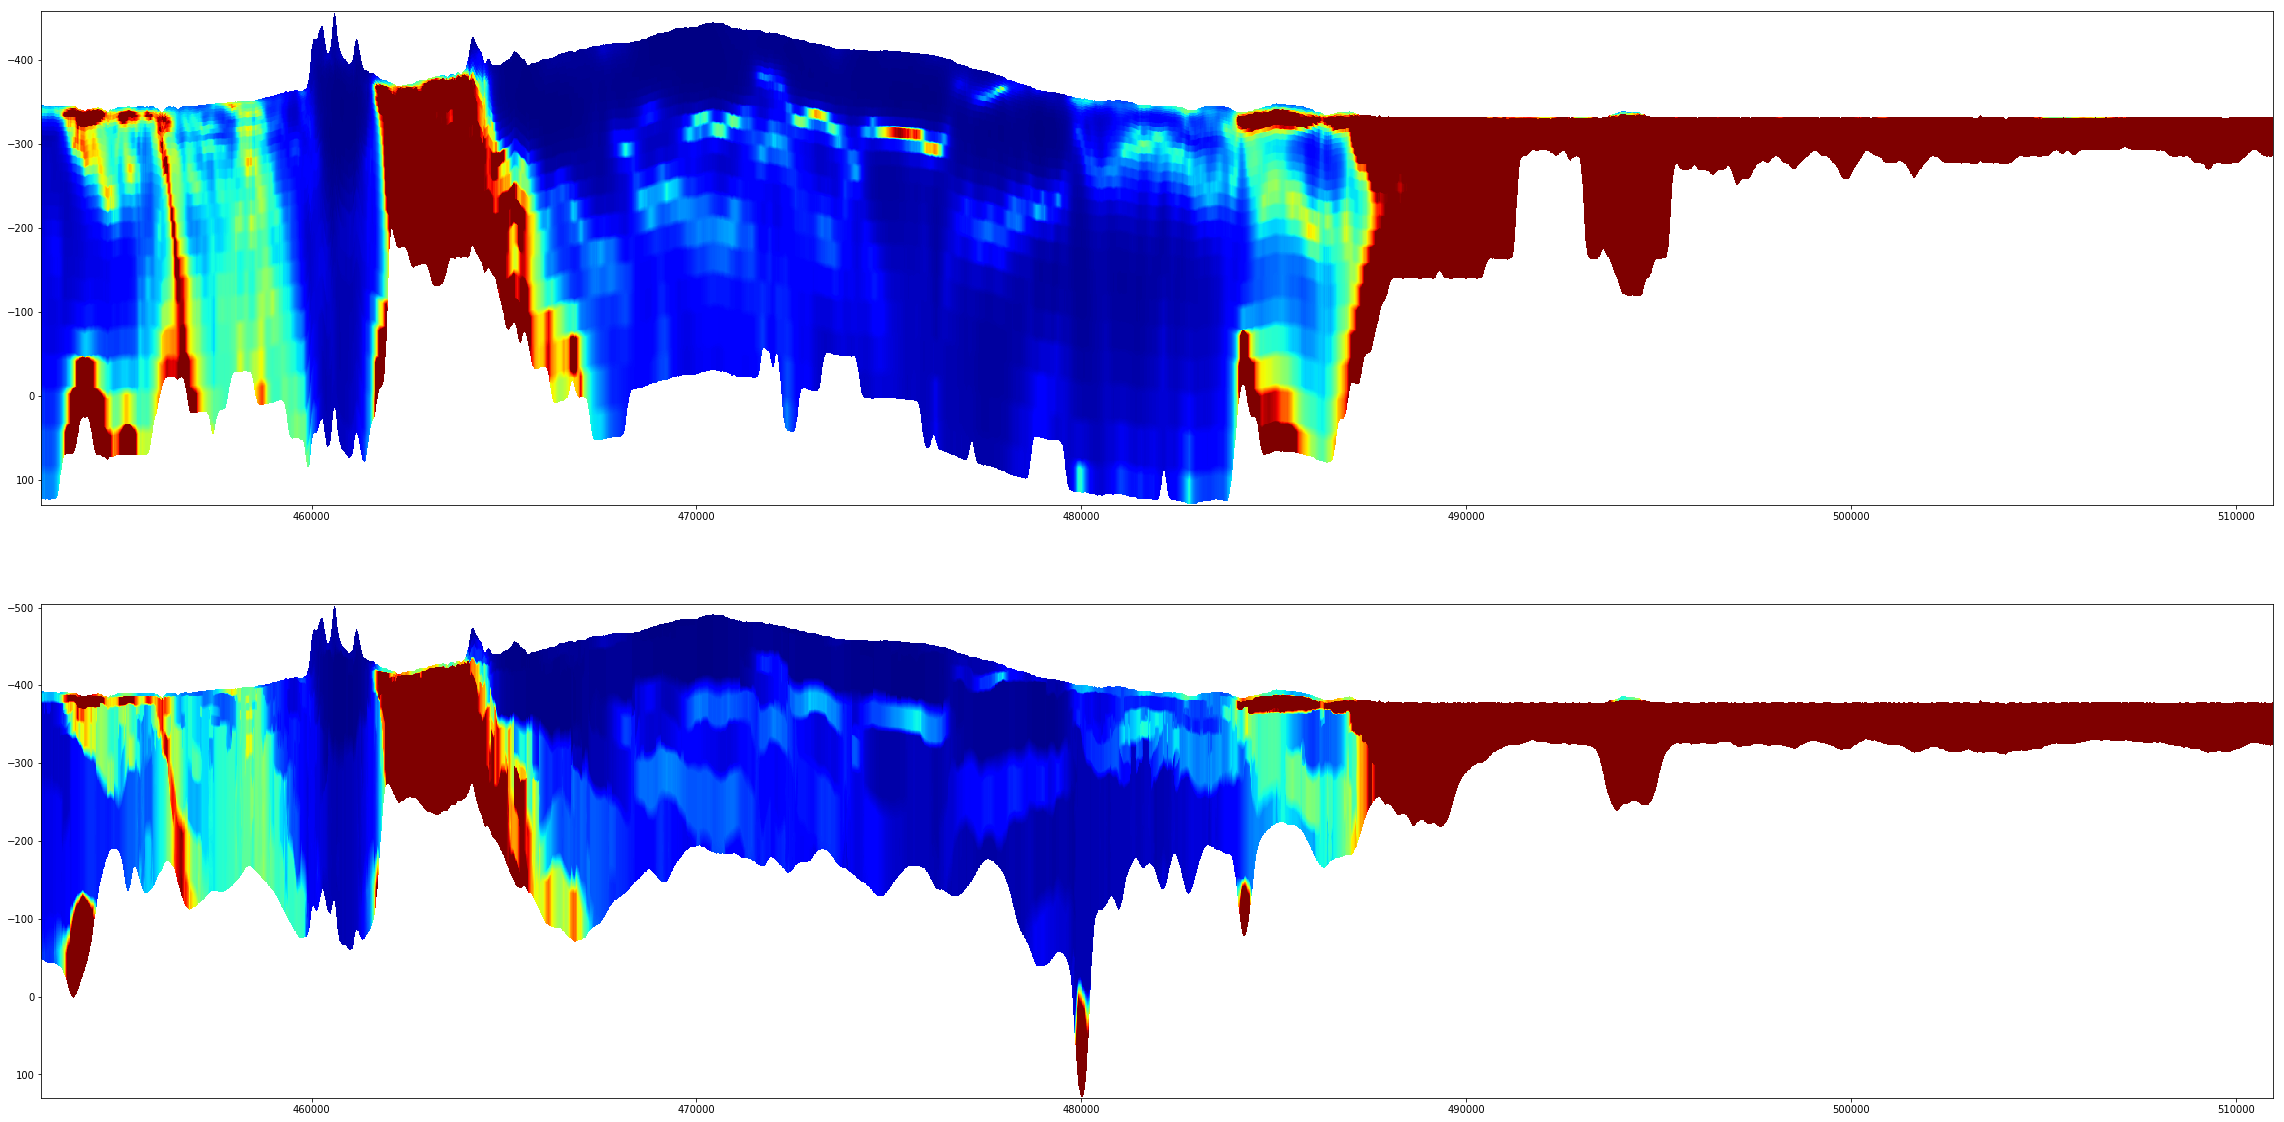

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40,20))    

im1 = ax1.imshow(cor2d_dict['conductivity'], vmin = 0., vmax = 0.1,
                 extent=(cor2d_dict['eastings'][0], cor2d_dict['eastings'][-1], cor2d_dict['elevations'][0],
                         cor2d_dict['elevations'][-1]),
                 aspect='auto',
                 cmap='jet')

im2 = ax2.imshow(malmo_dict['conductivity'], vmin = 0., vmax = 0.1,
                 extent=(malmo_dict['eastings'][0], malmo_dict['eastings'][-1], malmo_dict['elevations'][0],
                         malmo_dict['elevations'][-1]),
                 aspect='auto',
                 cmap='jet')

In [16]:
# NOw save these dictionaries into pickle files

import pickle

pickle_dir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\OB_AEM_interp\netCDF_conversion\sections_pickle\\'

for line in cor2d_dataset.variables['lines'][:]:
    

    section_dict = grid_section(cor2d_dataset, line, 'conductivity', layer_subdivisions = 4, xres = 10., yres = 1.,
                 resampling_method = 'linear')
    
    outfile = pickle_dir + str(int(line)) + '.pkl'
    
    with open(outfile, 'wb') as f:
        pickle.dump(section_dict, f)
    

C:\Users\u62231\AppData\Local\Continuum\anaconda3\envs\GDAL\lib\site-packages\ipykernel_launcher.py:78: UserWarning: Warning: converting a masked element to nan.


In [15]:
# Function for opening pickle file

pickle_dir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\OB_AEM_interp\netCDF_conversion\sections_pickle\\'

def open_section(line):
    path = pickle_dir + str(int(line)) + '.pkl'
    return pickle.load(open(path, 'rb'))

In [12]:
# NOw we will attempt to pull the point cloud out of the malmo inversions

malmo_dataset.variables['index_count']

<class 'netCDF4._netCDF4.Variable'>
int32 index_count(line)
    _FillValue: -1
    long_name: number of samples in the line
unlimited dimensions: 
current shape = (116,)
filling on

In [71]:
# Function for returning malmo point cloud

def point_cloud_collect(dataset, line):
    
    line_index = np.where(dataset.variables['lines'][...] == line)[0][0]

        
     # Get indices for extracting the variable data
        
    line_start = dataset.variables['index_line'][line_index]
    point_count = dataset.variables['index_count'][line_index]
    
    line_end = line_start + point_count
    line_slice = slice(line_start, line_end)
    
    # Create array of UTM coordinate pairs for all points in selected line
    utm_coordinates = np.zeros(shape=(point_count, 2), dtype=dataset.variables['easting'].dtype)
    utm_coordinates[:,0] = dataset.variables['easting'][line_slice]
    utm_coordinates[:,1] = dataset.variables['northing'][line_slice]


    nlayers = np.shape(dataset.variables['layer_top_depth'][line_slice])[1]

    layer_top_elevations = (np.repeat(dataset.variables['elevation'][line_slice][:, np.newaxis], nlayers, axis=1) - 
                                dataset.variables['layer_top_depth'][line_slice])
    
    # Extract conductivity
    
    layer_conductivities = dataset.variables['conductivity'][line_slice].reshape([-1,1])
    
    
    # Extract elevation of investiation
    
    eoi = np.repeat(np.subtract(layer_top_elevations[:,0], dataset.variables['depth_of_investigation'][line_slice]),
                    nlayers, axis = 0).reshape([-1,1])
    
    # Now repeat the utm coordinates so it can be joined into an x,y,z array

    utm_tiled = np.repeat(utm_coordinates, nlayers, axis = 0)
    
    # Now flatten and reshape the layertop elevation array

    lte = layer_top_elevations.flatten().reshape([-1,1])
    
    # Add a column with the layer number at each point
    
    layer_number = np.tile(np.arange(1,16), point_count).reshape([-1,1])

    
    # Horizontally stack the arrays and we have an layer boundary point cloud for this line
    layer_boundaries = np.hstack((utm_tiled, lte, layer_number, layer_conductivities, eoi))
    
    
    # Purge dummy layer boundaries
    layer_boundaries = layer_boundaries[layer_boundaries[:,2] > (-900 + 180)]
    
    # Purge values that are below the depth of investigation
    
    layer_boundaries = layer_boundaries[layer_boundaries[:,2] > layer_boundaries[:,4]]
    
    return layer_boundaries[:,:-1]
    

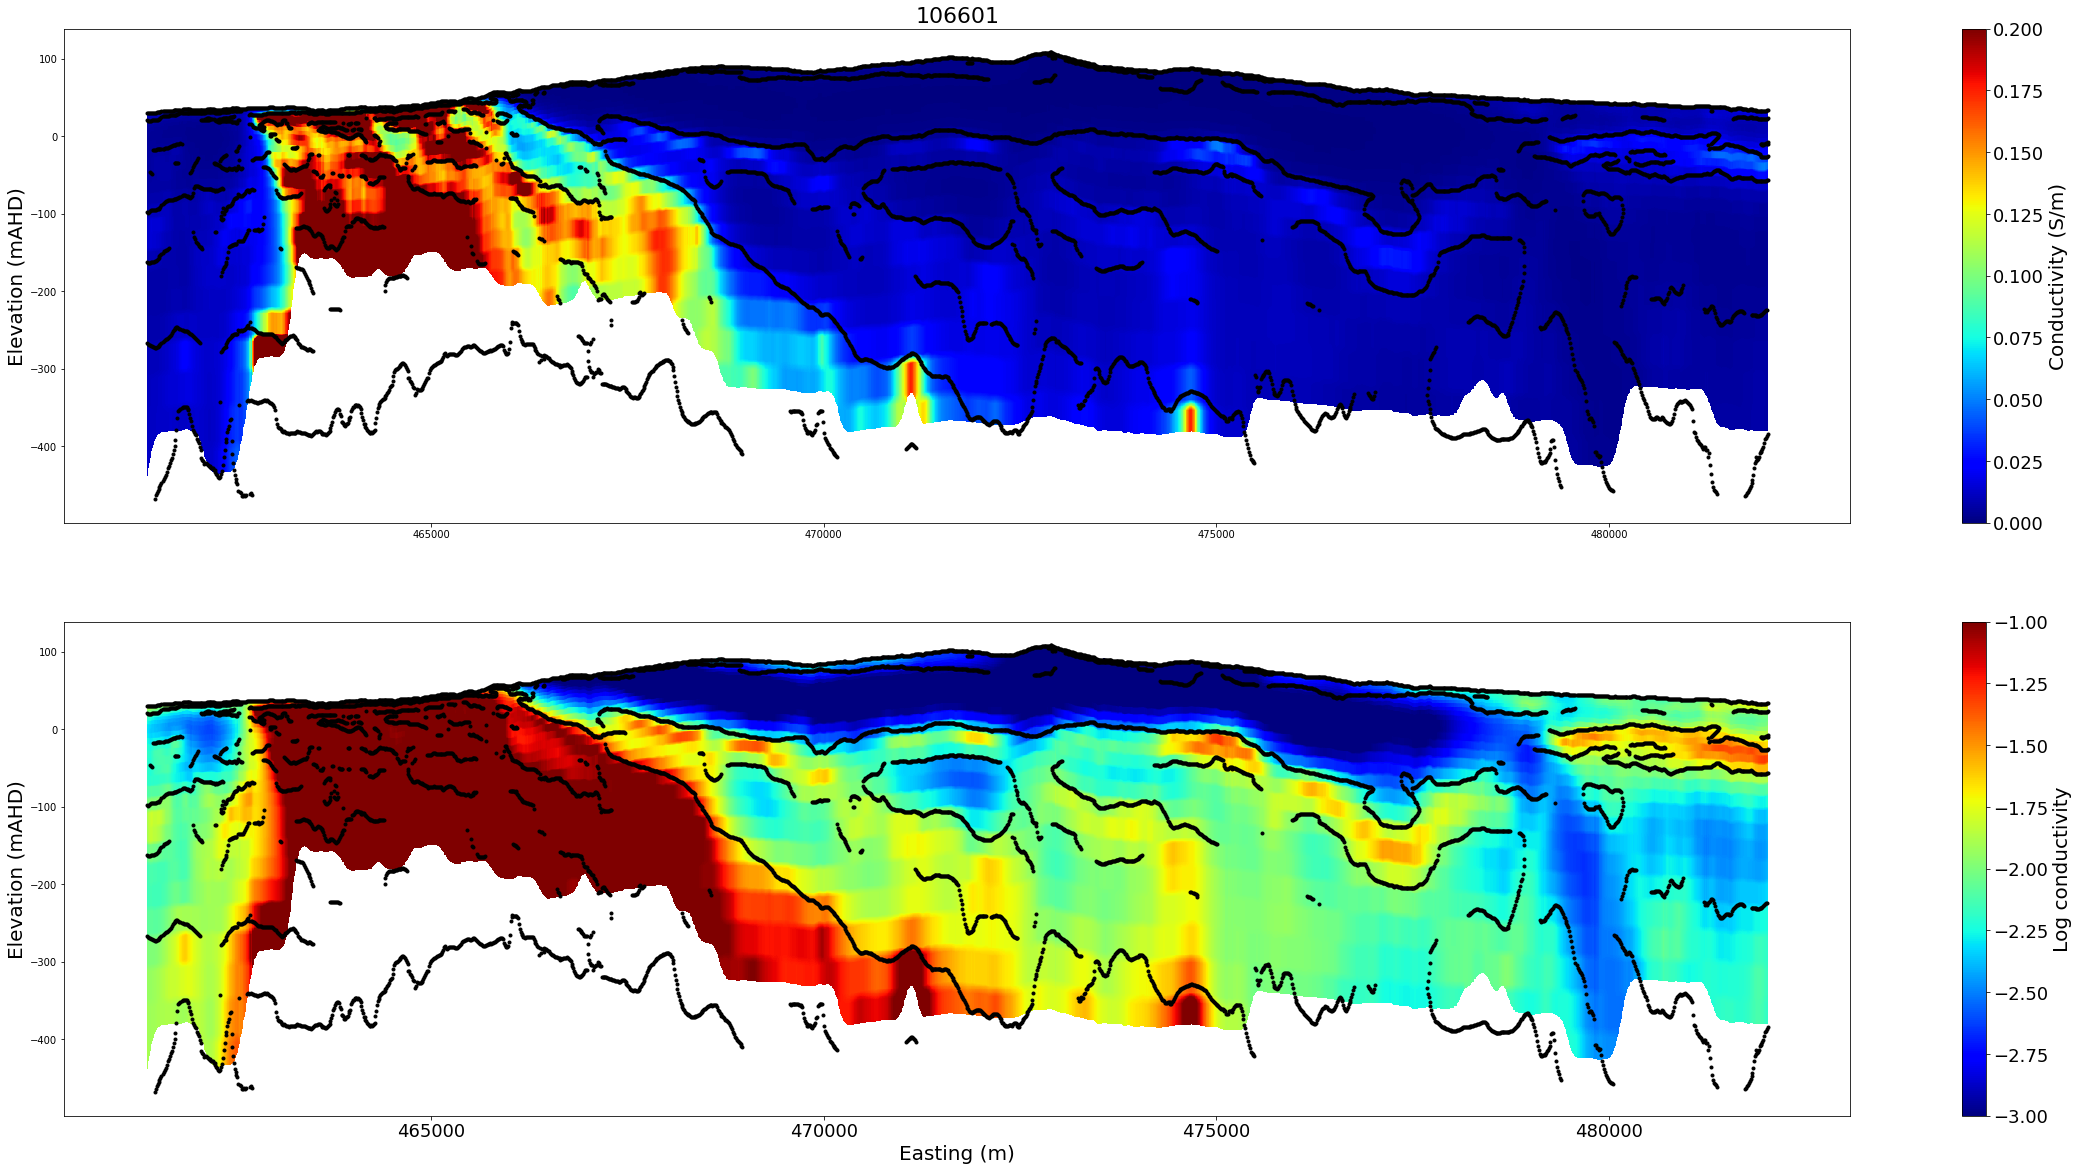

In [64]:
# Plot these on the section

plotdir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\OB_AEM_interp\netCDF_conversion\sections_plotted\\'

line = 106601

layer_boundaries = point_cloud_collect(malmo_dataset, line)

cond_dict = open_section(line)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40,20))    

ax1.set_title(str(line), fontsize = 22)

im1 = ax1.imshow(cond_dict['conductivity'], vmin = 0., vmax = 0.2,
                 extent=(cond_dict['eastings'][0], cond_dict['eastings'][-1], cond_dict['elevations'][-1],
                         cond_dict['elevations'][0]),
                 aspect='auto',
                 cmap='jet')

cb = plt.colorbar( im1, ax=ax1)
cb.set_label('Conductivity (S/m)', fontsize = 20)
cb.ax.tick_params(labelsize=18)

im2 = ax2.imshow(np.log10(cond_dict['conductivity']), vmin = -3, vmax = -1,
                 extent=(cond_dict['eastings'][0], cond_dict['eastings'][-1], cond_dict['elevations'][-1],
                         cond_dict['elevations'][0]),
                 aspect='auto',
                 cmap='jet')
ax1.set_ylabel('Elevation (mAHD)', fontsize = 20)
ax2.set_ylabel('Elevation (mAHD)', fontsize = 20)
ax2.set_xlabel('Easting (m)', fontsize = 20)


cb = plt.colorbar( im2, ax=ax2)
cb.set_label('Log conductivity',fontsize = 20)
cb.ax.tick_params(labelsize=18)

ax1.scatter(layer_boundaries[:,0], layer_boundaries[:,2], marker = '.', c = 'k')

ax2.scatter(layer_boundaries[:,0], layer_boundaries[:,2],marker = '.', c = 'k')


plt.xticks(fontsize=18)

plt.show()
#plt.savefig(plotdir + str(line) + '.png', bbox_inches='tight')


100102


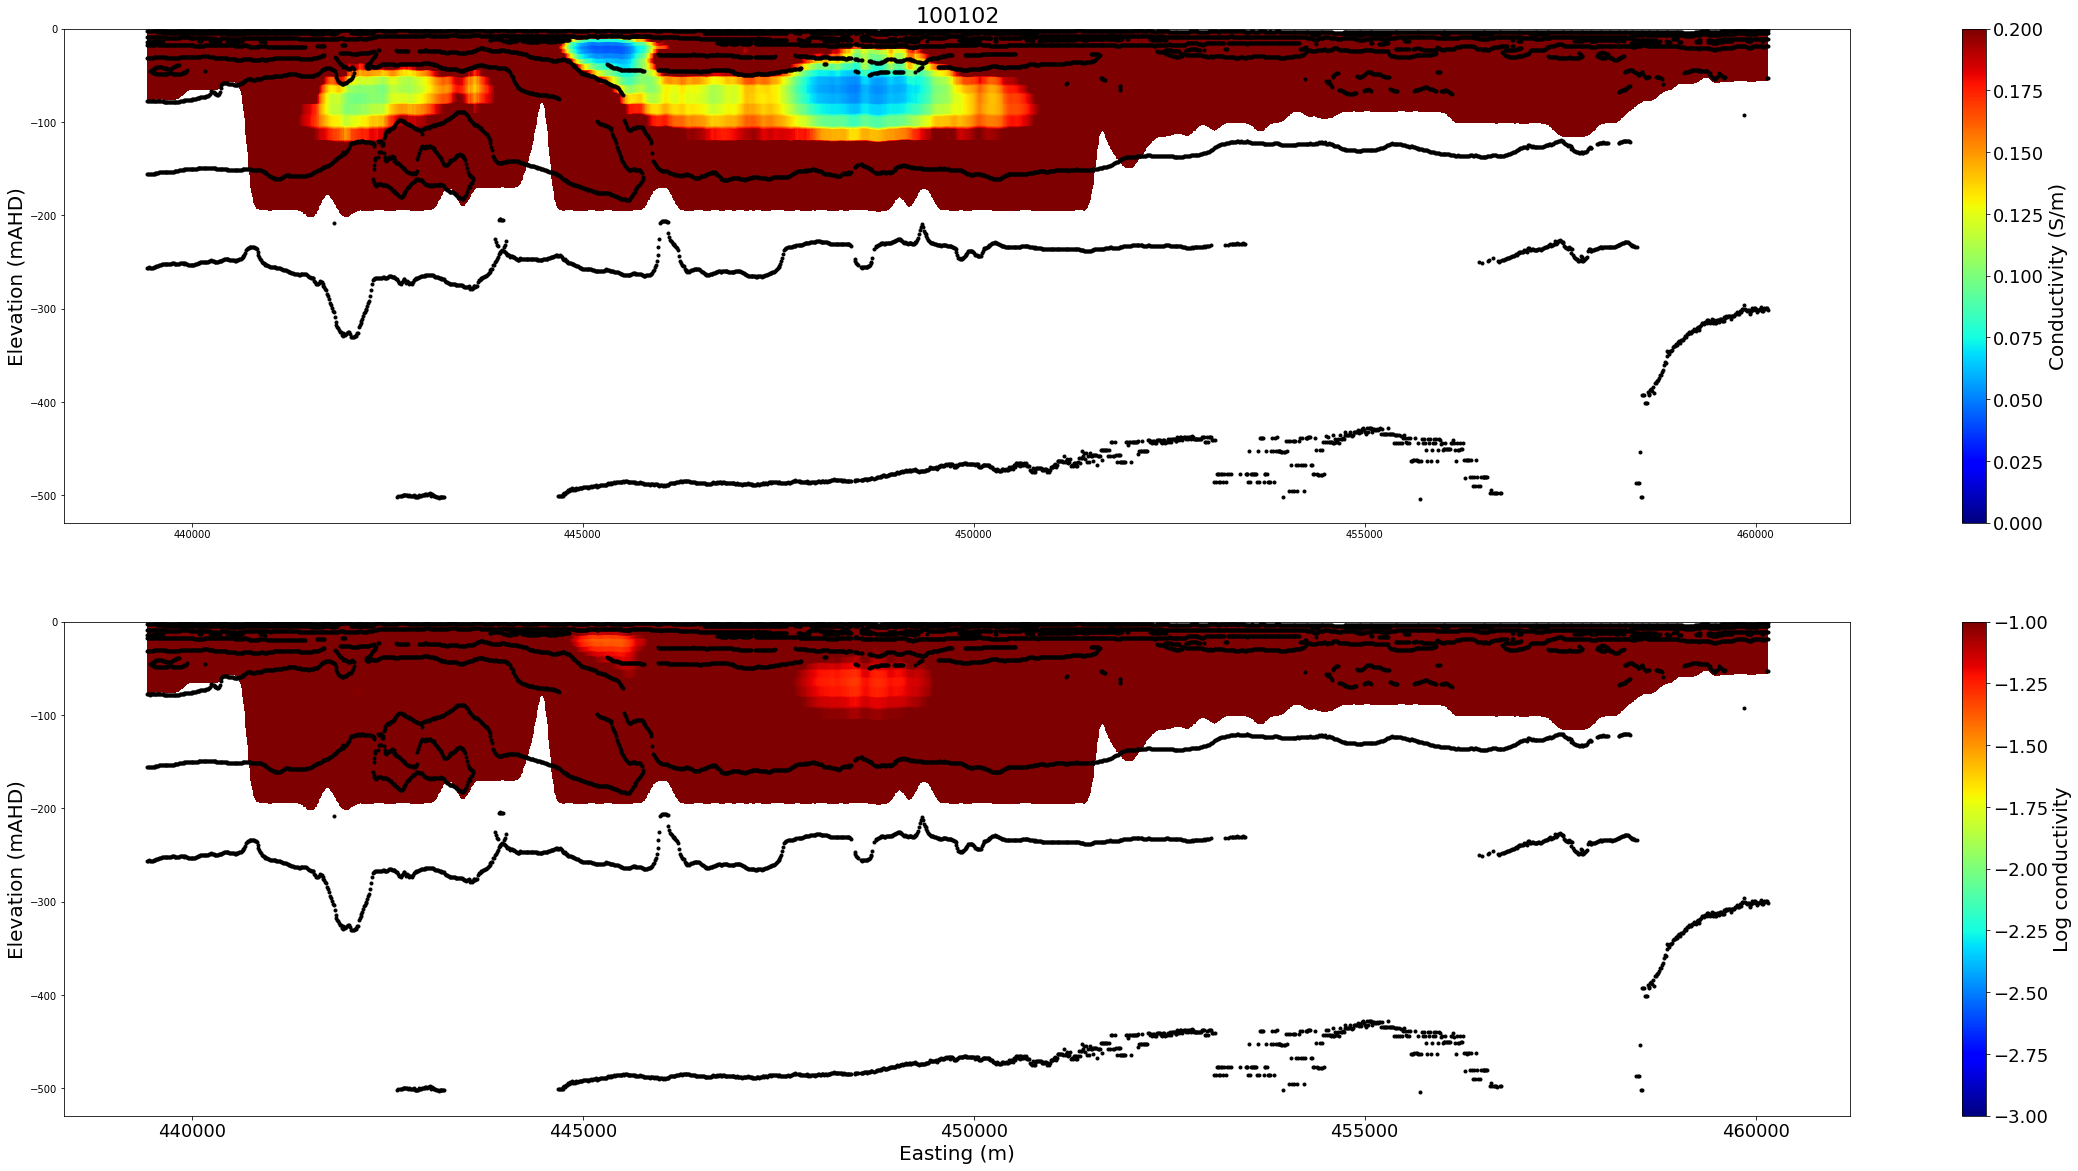

In [65]:
#Iterate through and save the figures out

for line in cor2d_dataset.variables['lines'][:]:
    print(line)
    
    layer_boundaries = point_cloud_collect(malmo_dataset, line)

    cond_dict = open_section(line)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(40,20))    

    ax1.set_title(str(line), fontsize = 22)

    im1 = ax1.imshow(cond_dict['conductivity'], vmin = 0., vmax = 0.2,
                     extent=(cond_dict['eastings'][0], cond_dict['eastings'][-1], cond_dict['elevations'][-1],
                             cond_dict['elevations'][0]),
                     aspect='auto',
                     cmap='jet')

    cb = plt.colorbar( im1, ax=ax1)
    cb.set_label('Conductivity (S/m)', fontsize = 20)
    cb.ax.tick_params(labelsize=18)

    im2 = ax2.imshow(np.log10(cond_dict['conductivity']), vmin = -3, vmax = -1,
                     extent=(cond_dict['eastings'][0], cond_dict['eastings'][-1], cond_dict['elevations'][-1],
                             cond_dict['elevations'][0]),
                     aspect='auto',
                     cmap='jet')
    ax1.set_ylabel('Elevation (mAHD)', fontsize = 20)
    ax2.set_ylabel('Elevation (mAHD)', fontsize = 20)
    ax2.set_xlabel('Easting (m)', fontsize = 20)


    cb = plt.colorbar( im2, ax=ax2)
    cb.set_label('Log conductivity',fontsize = 20)
    cb.ax.tick_params(labelsize=18)

    ax1.scatter(layer_boundaries[:,0], layer_boundaries[:,2], marker = '.', c = 'k')

    ax2.scatter(layer_boundaries[:,0], layer_boundaries[:,2],marker = '.', c = 'k')

    plt.xticks(fontsize=18)

    break#plt.savefig(plotdir + str(line) + '.png', bbox_inches='tight')

In [72]:
#Iterate through and save the data as a csv file

outdir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\OB_AEM_interp\netCDF_conversion\layer_boundary_point_clouds\\'

header = 'Easting,Northing,layer_top_elevation(mAHD),layer_number,conductivity_(S/m)'

for line in cor2d_dataset.variables['lines'][:]:
    print(line)
    
    layer_boundaries = point_cloud_collect(malmo_dataset, line)
    
    with open(outdir + str(line) + '_doi' + '.csv', 'w') as f:
        f.write(header + '\n')
        np.savetxt(f, layer_boundaries, delimiter = ',')
    
    #np.save(outdir + str(line) + '.npy', layer_boundaries)

100102
100202
100302
100401
100501
100601
100701
100801
100901
101001
101102
101202
101301
101402
101502
101602
101702
101801
101901
102001
102101
102102
102201
102301
102401
102501
102601
102701
102801
102802
102901
103001
103101
103201
103301
103302
103401
103501
103601
103701
103801
103901
104001
104101
104201
104301
104401
104501
104601
104701
104801
104901
105001
105101
105201
105301
105401
105501
105601
105701
105801
105901
106001
106101
106201
106301
106401
106501
106601
106701
106801
106901
107001
107101
107201
107301
107401
107501
107601
107701
107702
107801
107901
108001
108101
108201
108301
108401
108501
108502
108601
108701
108801
108901
108902
109001
109101
109201
109301
109302
109401
109501
109601
500102
500201
500301
500401
500501
500601
912001
912002
912003
912004
912005
912006
912007
